# Imports and auxiliary functions for plotting

In [1]:
import pandas as pd
import numpy as np
import io
import re
import pickle

In [2]:
import torch
from torch.distributions import Normal

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns; sns.set(); sns.set(font_scale=1.0); sns.set_style("white"); 

import matplotlib as mpl
from matplotlib import pyplot as plt

def _reset_mpl_config(font_size = 17*1.5, cmbright=True):
    mpl.rcParams.update(mpl.rcParamsDefault) #reset to defaults
        
    SMALL_SIZE = font_size-4
    MEDIUM_SIZE = font_size
    BIGGER_SIZE = font_size
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.rc('font',**{'family':'serif','serif':['Times'], "weight": "normal"})
    plt.rc('text', usetex=True)
    plt.rc('mathtext', fontset='stix')  #['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
    
    mpl.rcParams['text.latex.preamble'] = [
            r'\usepackage{mathtools}',
            r'\usepackage{amsmath}',
            r'\usepackage{amsfonts}', 
            r'\usepackage{microtype}',    
            r'\usepackage{arydshln}',              
    ] + ([r'\usepackage{cmbright}'] if cmbright else [])

def _create_fig(bottom=0.2, left=0.125, right=0.9, top=0.9):
    fig = plt.figure(figsize=(6.4, 4.8), dpi=72)
    fig.subplots_adjust(bottom=bottom, left=left, right=right, top=top) 
    
    
def start_plotting(cmbright=True, font_size=17*1.5, bottom=0.2, left=0.125, right=0.95, top=0.95):
    _reset_mpl_config(cmbright=cmbright, font_size=font_size)
    _create_fig(bottom=bottom, left=left, right=right, top=top)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
GREEN = "limegreen"#sns.color_palette("Greens")[2]
BLUE = "dodgerblue" #sns.color_palette("Blues")[2]
RED = "salmon" #sns.color_palette("Reds")[2]
    
BLUES = ["#4682B4", "#5F9EA0", "#7B68EE", "#6A5ACD", "#483D8B", "#4169E1", "#0000FF", "#0000CD", "#00008B", "#000080", "#191970", "#8A2BE2", "#4B0082", "#F0F8FF", "#E6E6FA", "#B0E0E6", "#ADD8E6", "#87CEFA", "#87CEEB", "#00BFFF", "#B0C4DE", "#1E90FF", "#6495ED"]
REDS = ["#FFA07A", "#E9967A","#F08080","#CD5C5C","#DC143C","#B22222","#FF0000","#8B0000","#800000","#FF6347","#FF4500","#DB7093"]    
GREENS = ["#7CFC00", "#7FFF00", "#32CD32", "#00FF00", "#228B22", "#008000", "#006400", "#ADFF2F", "#9ACD32", "#00FF7F", "#00FA9A", "#90EE90", "#98FB98", "#8FBC8F", "#3CB371", "#20B2AA", "#2E8B57", "#808000", "#556B2F", "#6B8E23"]
COLORS = ['dodgerblue', 'salmon',  'limegreen', 'teal', 'mediumspringgreen', 'violet',  'crimson'] 

# Loss/utility

In [6]:
def optimal_h(ys, q): 
    if q==-1: # SQUARED LOSS
        return ys.mean(0)
    
    quantiles = np.percentile((ys), int(q*100), axis=0) # TILTED LOSS
    return quantiles

# Model

In [7]:
def flatten_first_two_dims(t):
    return t.view( (t.shape[0]*t.shape[1], ) + t.shape[2: ] )

# ## Sampling from predictive posterior distribution
def sample_predictive_y0(qw, qz, nsamples_theta, nsamples_y):  
    """ Returns a tensor with samples     
        (nsamples_y samples of y for each theta x 
         nsamples_theta samples of latent variables)."""
    w = qw.rsample(torch.Size([nsamples_theta]))
    z = qz.rsample(torch.Size([nsamples_theta]))    
    
    xhat = z.matmul(w)
    likelihood = Normal(xhat, 1.)
    y_samples = likelihood.rsample(torch.Size([nsamples_y]))
    return y_samples


def sample_predictive_y(qw, qz, nsamples_theta, nsamples_y):  
    """ Returns a tensor with samples (nsamples_y x nsamples_theta).
        Flattents the first two dimensions 
        (samples of y for different thetas) from sample_predictive_y0.
    """
    return flatten_first_two_dims(sample_predictive_y0(qw, qz, nsamples_theta, nsamples_y))

# Data

In [8]:
env = torch

def lastfm_data(N=1000, D=100, url="../../data/lastfm_data.csv"):    
    """LastFm views."""
    df = pd.read_csv(url, header=None)
    x_ = df.values #users in rows, artists in colums
    x_ = x_[:N, :D]
    N, D = x_.shape

    x_ = np.log(1+x_)
    mask_ = np.ones( (N,D), dtype=bool) #non-missing values
    return x_, mask_


# Prepares data to work with pytorch
x_, mask_ = lastfm_data()
x    = torch.tensor(x_, dtype = torch.float, requires_grad=False)
mask = torch.tensor(mask_.astype(np.uint8)).type(env.ByteTensor) # non-missing values
N, D = x.shape


# ## Training vs. test split
def random_mask(x, testing_prob=0.5, seed=123): 
    np.random.seed(seed)
    N, D = x.shape
    testing_mask = np.random.choice([0, 1], (N, D), (1.0-testing_prob, testing_prob))
    training_mask = np.ones((N, D))-testing_mask
    return training_mask, testing_mask


# Prepares masks to work with pytorch
training_mask, testing_mask = random_mask(x)
training_mask = torch.tensor((training_mask*mask_).astype(np.uint8)).type(env.ByteTensor)
testing_mask  = torch.tensor((testing_mask*mask_).astype(np.uint8)).type(env.ByteTensor)
N, D = training_mask.shape

In [9]:
ix2artist = pd.read_csv("../../data/lastfm_ix2artist.csv", header=None)
ix2user = pd.read_csv("../../data/lastfm_ix2user.csv", header=None)

ix2artist = dict(zip(ix2artist[0],ix2artist[1]))
ix2user = dict(zip(ix2user[0],ix2user[1]))

# Loading posteriors

In [10]:
Qs = [0.2,0.5,0.8,-1] # order of plots: -1 means squared loss
DIR = "RESULTS_PICKLES/"
LCVI_PICKLES = ["naive1.0_0_tilted0.2_exp.pickle",
                "naive1.0_0_tilted0.5_exp.pickle",
                "naive1.0_0_tilted0.8_exp.pickle",
                "naive1.0_0_squared0.2_exp.pickle"]
VI_PICKLE = "vi1.0_0_squared0.2_exp.pickle"

In [11]:
NSAMPLES = 100

ylcvi = []
for pickle_file in LCVI_PICKLES:    
  qw, qz = pickle.load(open(DIR+pickle_file, "rb"))
  ylcvi.append(sample_predictive_y(qw, qz, NSAMPLES, 1).detach().numpy())
  
qw, qz = pickle.load(open(DIR+VI_PICKLE, "rb"))
yvi = sample_predictive_y(qw, qz, NSAMPLES, 1).detach().numpy()  

In [12]:
# Decisions:
hvi   = [optimal_h(yvi, q) for q in Qs]
hlcvi = [optimal_h(ys, q)  for q, ys in zip(Qs,ylcvi)]

# Plots

## Predictive Posteriors

In [13]:
Q1, Q2 = 5, 95

In [14]:
YSCALE = False #true is for logscale

COLS = [
"pink",
"salmon",
"red",
"firebrick"]

def _plot_user2(uix, artist_ixs=list(range(5)), title="[user]", 
              legend=False, xlabel=False, ylabel=False, offset = 0.12, yscale=YSCALE, line1=True):
    print("plotting uix=%i artist_ixs=%s" % (uix, artist_ixs))
    
    training_artist_ixs = [aix for aix in artist_ixs if training_mask[uix,aix]==1]
    testing_artist_ixs = [aix for aix in artist_ixs if testing_mask[uix,aix]==1]

    pos = np.array(range(len(artist_ixs)))
    training_pos = [pos-0.2 for pos,aix in enumerate(artist_ixs) if training_mask[uix,aix]==1]
    testing_pos = [pos-0.2 for pos,aix in enumerate(artist_ixs) if testing_mask[uix,aix]==1]

    #plt.subplots_adjust(hspace=0.45)
    
    
    yvil, yviu = np.percentile(yvi, [Q1, Q2], axis=0)
    yvim, yvis = (yvil+yviu)*0.5, (yviu-yvil)*0.5        
    plt.errorbar(pos-offset-0.2, yvim[uix,artist_ixs], yerr=yvis[uix,artist_ixs],
                 fmt='-', lw=0, color="dodgerblue", ecolor="dodgerblue", elinewidth=1.5, capsize=2, label="VI", 
                 barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

    
    for i, (q, ys, hs) in enumerate(zip(Qs, ylcvi, hlcvi)):
        ylcvil, ylcviu = np.percentile(ys, [Q1, Q2], axis=0)
        ylcvim, ylcvis = (ylcvil+ylcviu)*0.5, (ylcviu-ylcvil)*0.5
        
        color = COLS[i] if q>=0 else "greenyellow"
        label = r"$q=%.1f$" % q if q>=0 else "Squared"
        p = pos+(i+1)*offset-0.2
        plt.errorbar(p, ylcvim[uix,artist_ixs], yerr=ylcvis[uix,artist_ixs], 
                     fmt='-', lw=0, color=color, ecolor=color, elinewidth=1.5, capsize=2, label=label,
                     barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)        
        plt.scatter(p, hs[uix,artist_ixs], marker="d", s=20, color=color)


    plt.scatter(training_pos, x[uix, training_artist_ixs], color="k", label="Training", marker="x", s=20)
    plt.scatter(testing_pos, x[uix, testing_artist_ixs], color="k", label="Test", marker="o", s=20)

    
    if line1: plt.axhline(y=1, color="gray", ls="--")

    names = [ix2artist[aix] for aix in artist_ixs]
    plt.xticks(pos, names, rotation=45, ha="right")
    
    #plt.title(title.replace("[user]", ix2user[uix].replace("_", " ").replace(" 000", " ")), fontsize=17*1.3)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    xpos = 1 # (xmax+xmin)*0.5
    ypos = ymin+(ymax-ymin)*0.95
    plt.text(xpos, ypos, 
             title.replace("[user]", ix2user[uix].replace("_", " ").replace(" 000", " ")), 
             fontsize=17*1.3, va="top", ha="center")
    
    if xlabel: plt.xlabel("artist")
        
    if yscale:
        plt.yscale("log")
        y0,y1 = plt.ylim()
        y0 = YMIN
        plt.ylim(y0, y1)

    if legend: plt.legend(fontsize=17)

plotting uix=1 artist_ixs=[0, 99]
plotting uix=124 artist_ixs=[0, 99, 23]


<Figure size 460.8x345.6 with 0 Axes>

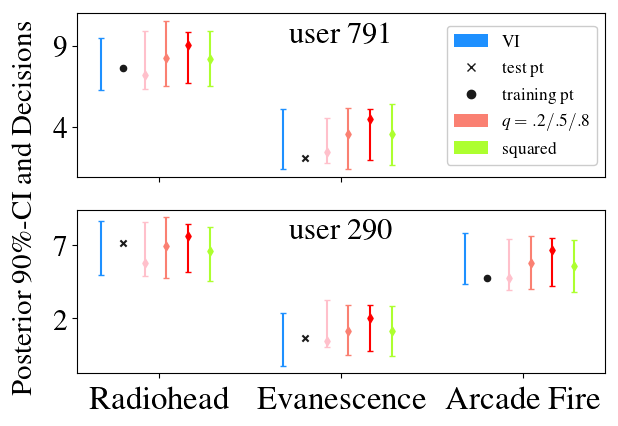

In [15]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

start_plotting(cmbright=False, font_size=17*1.5, bottom=0.2)#left=0.2)
fig, ax = plt.subplots(2,1) 
bands = [0,99,23]


plt.sca(ax[0]);
_plot_user2(1, bands[:2], title="[user]", ylabel=True, legend=False, line1=False)
plt.xticks([0,1],[])
plt.yticks([4,9],["4", "9"], fontsize=17*1.25)
plt.xlim(-0.45,2.45)
legend_elements = [Patch(facecolor='dodgerblue', edgecolor=None,
                         label='VI'),
                   Line2D([0], [0], marker='x', color='k', lw=0, label='test pt',
                          markerfacecolor='k', markersize=6),                   
                   Line2D([0], [0], marker='o', color='k', lw=0, label='training pt',
                          markerfacecolor='k', markersize=6),                                      
                   Patch(facecolor='salmon', edgecolor=None,
                         label=r'$q=.2/.5/.8$'),                  
                   Patch(facecolor='greenyellow', edgecolor=None,
                         label=r'squared')]
legend = plt.legend(loc=5, handles=legend_elements, fontsize=12.5)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1.0)
plt.subplots_adjust(bottom=0.2)

plt.sca(ax[1]);
_plot_user2(124, bands, title="[user]", ylabel=True, legend=False, line1=False)
plt.xticks(rotation=0, ha="center", fontsize=17*1.4)
plt.xlim(-0.45,2.45)
plt.yticks([2,7],["2", "7"], fontsize=17*1.25)
fig.text(0.02, 0.545, 'Posterior 90\%-CI and Decisions', va='center', rotation='vertical', fontsize=21)

plt.subplots_adjust(left=0.125, bottom=0.2, top=0.95, right=0.95)
plt.savefig("mf_sample_posteriors.pdf")
plt.show()

## Difference in decisions

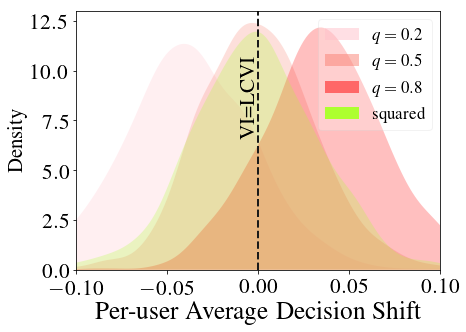

In [16]:
COLS = [
"pink",
"salmon",
"red",
"firebrick"]

start_plotting(cmbright=False, font_size=1.5*17, left=0.16)
label_patches = []
for i, q in enumerate(Qs):
    d = (hvi[i]-hlcvi[i]).mean(1)
    if q>=0:
        color, label = (COLS[i], r"$q=%.1f$" % q)  
        sns.kdeplot(d, lw=0, color=color, label=label, alpha=0.25, gridsize=200, 
                    bw="scott", facecolor=color, shade=True)
        label_patches.append(mpatches.Patch(color=color,label=label, alpha=0.5, lw=0)) 
    else:
        color, label =("greenyellow", "squared")    
        sns.kdeplot(d, lw=0, color=color, label=label, alpha=0.25, gridsize=200, 
                    bw="scott", facecolor=color, shade=True, ls="-")
        label_patches.append(mpatches.Patch(color=color,label=label, alpha=1.0, lw=0)) 
y1,y2 = plt.ylim()
plt.axvline(x=0, color="k", ls="--", lw=2); plt.text(0,(y1+y2)/2,"VI=LCVI", rotation=90, ha="right", va="bottom")
plt.xlim(-0.1, 0.1)
plt.grid(False)
plt.xlabel("Per-user Average Decision Shift ")
plt.ylabel("Density", fontsize=21)
l = plt.legend(loc=1, handles=label_patches, fontsize=17)
frame = l.get_frame()
frame.set_alpha(0.25)
plt.savefig("mf_users_decision_shifts.pdf")
plt.show();

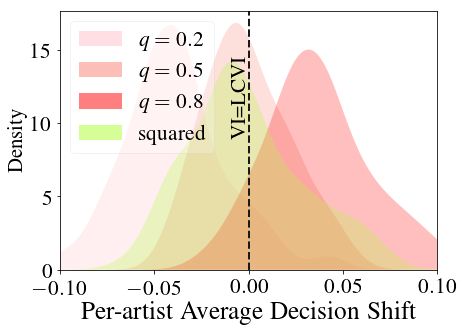

In [17]:
COLS = [
"pink",
"salmon",
"red",
"firebrick"]


start_plotting(cmbright=False, font_size=17*1.5, left=0.13)
label_patches = []
for i, q in enumerate(Qs):
    d = (hvi[i]-hlcvi[i]).mean(0)
    if q>=0:
        color, label = (COLS[i], r"$q=%.1f$" % q)  
        sns.kdeplot(d, lw=0, color=color, label=label, alpha=0.25, gridsize=200, 
                    bw="scott", facecolor=color, shade=True)
    else:
        color, label =("greenyellow", "squared")    
        sns.kdeplot(d, lw=0, color=color, label=label, alpha=0.25, gridsize=200, 
                    bw="scott", facecolor=color, shade=True, ls="-")
    label_patches.append(mpatches.Patch(color=color,label=label, alpha=0.5, lw=0)) #sns.color_palette("Blues")[2]
y1,y2 = plt.ylim()
plt.axvline(x=0, color="k", ls="--", lw=2); plt.text(0,(y1+y2)/2,"VI=LCVI", rotation=90, ha="right", va="bottom")
plt.xlim(-0.1, 0.1)
plt.grid(False)
plt.xlabel("Per-artist Average Decision Shift")
plt.ylabel("Density", fontsize=21)
l = plt.legend(loc=2, handles=label_patches)
frame = l.get_frame()
frame.set_alpha(0.25)
plt.savefig("mf_artist_decision_shifts.pdf")
plt.show();